<a href="https://colab.research.google.com/github/chi-hun/chi-hun/blob/main/librosa(_wav).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.auto import tqdm

In [50]:
!unzip '/content/drive/MyDrive/Colab Notebooks/공부/wav_sample.zip'
wav_list = sorted(glob.glob('/content/wav_sample/*.wav'))

Archive:  /content/drive/MyDrive/Colab Notebooks/공부/wav_sample.zip
   creating: wav_sample/
  inflating: wav_sample/chimes.wav   
  inflating: wav_sample/notify.wav   
  inflating: wav_sample/Speech Off.wav  
  inflating: wav_sample/tada.wav     


In [60]:
for wav_file in wav_list:
    wav, samplerate = librosa.load(wav_file)
    print( '='*10, wav_file.split('/')[-1].split('.')[0], '='*10)
    print(f'wav : {wav}')
    print(f'sampling rate : {samplerate}')
    print(f'lenth : {len(wav) / samplerate}\n')

========== Speech Off ==========
wav : [-4.3493305e-06  1.0526149e-06  9.3073959e-06 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
sampling rate : 22050
lenth : 1.0681179138321995

========== chimes ==========
wav : [-1.32502309e-05 -1.09836155e-05 -2.95859763e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
sampling rate : 22050
lenth : 1.2263038548752834

========== notify ==========
wav : [0. 0. 0. ... 0. 0. 0.]
sampling rate : 22050
lenth : 1.294512471655329

========== tada ==========
wav : [0. 0. 0. ... 0. 0. 0.]
sampling rate : 22050
lenth : 1.6166893424036282



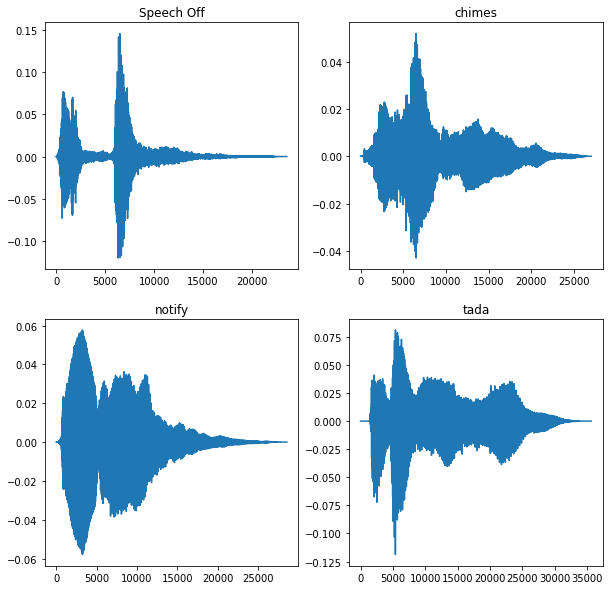

In [62]:
plt.figure(figsize=(10,10))
for i, wav_file in enumerate(wav_list):
    plt.subplot(2, 2 ,i+1)
    wav,_ = librosa.load(wav_file)
    plt.title(wav_file.split('/')[-1].split('.')[0])
    plt.plot(wav)
plt.show()

# Fourier Transform

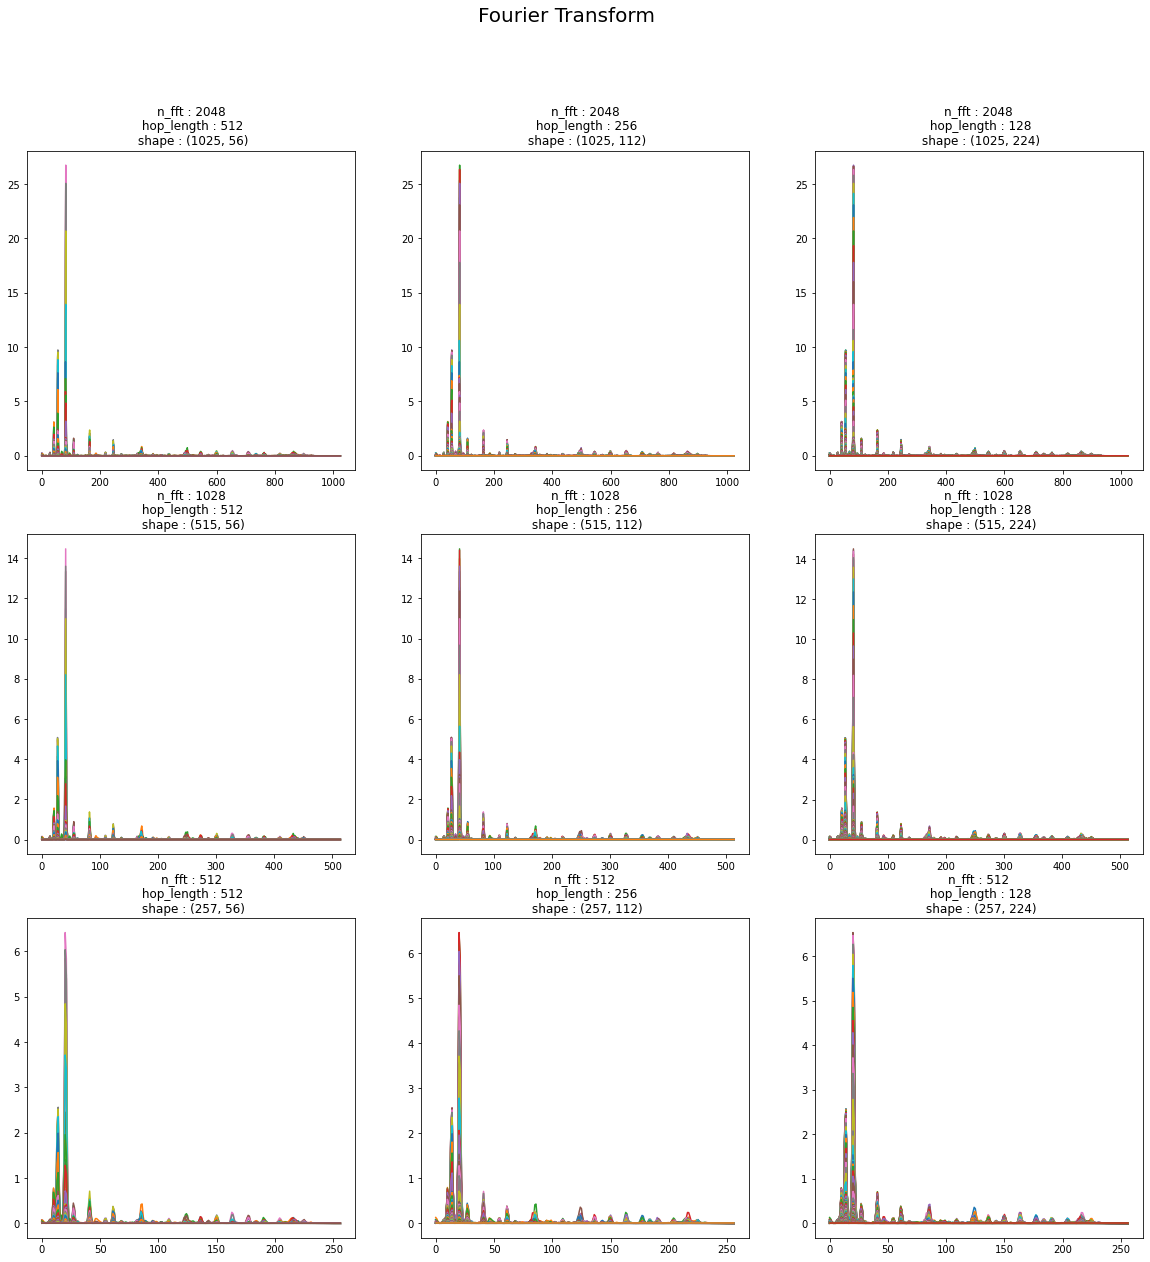

In [45]:
n_fft_li = [2048, 1028, 512]
hop_length_li = [512, 256, 128]
n_subplot = 1
plt.figure(figsize=(20,20))
plt.suptitle('Fourier Transform', fontsize=20)
for i in n_fft_li:
    for j in hop_length_li:
        wave_stft = np.abs(librosa.stft(wav, n_fft = i, hop_length = j))
        plt.subplot(3 ,3, n_subplot)
        plt.title(f'n_fft : {i}\n hop_length : {j}\n shape : {wave_stft.shape}')
        plt.plot(wave_stft)
        n_subplot += 1
plt.show()

1. **melspectrogram**

사람은 낮은 주파수를 높은 주파수보다 더 예민하게 받아들임

500 ~ 1500 Hz 가 바뀌는건 예민하게 인식하는데 반해 10000Hz ~ 11000Hz가 바뀌는 것은 잘 인식 못한다는 것.

주파수 단위를 다음 공식에 따라 멜 스케일로 변환 m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)m=2595log10​(1+700f​)

해당 scale을 적용해 spectogram을 만든 것이 melspectogram
2. **mfcc**

Mel-Spectrogram이라는 피쳐에 대해 행렬을 압축해서 표현해주는 DCT 연산을 수행

3. **melspectrogram vs mfcc**

Mel-Spectrogram의 경우 주파수끼리 Correlate하기 때문에 도메인이 한정적인 문제에서 더 좋은 성능을 보이고,
MFCC의 경우는 De-Correlate를 해주기 때문에 일반적인 상황에서 더 좋은 성능을 보여준다고 함.

In [220]:
sr = 22050

def mfcc(wav, sample_rate, n_mfcc):
    wav = librosa.feature.mfcc(wav, sr = sample_rate, n_mfcc = n_mfcc)
    return wav

def mel_spectrogram(wav, sample_rate, n_mel):
    wav = librosa.feature.melspectrogram(wav, sr=sample_rate, n_mels=n_mel)
    wav = librosa.power_to_db(wav, ref=np.max)
    return wav

def padding(wav, end_size): # 최대길이 70, 80
    pad_size = end_size - wav.shape[1]
    pad_left = int(pad_size * np.random.rand())
    pad_right = pad_size - pad_left
    wav = np.pad(wav, ((0,0),(pad_left, pad_right)), mode='constant')
    return wav

def minmax_sc(wav):
    wav_max = wav.max()
    wav_min = wav.min()
    wav = (wav - wav_min)/(wav_max - wav_min)
    return wav

def minmax_padding(wav, end_size, mode):
    if mode == 'mfcc':  # 평균이 높다
        wav = padding(wav, end_size)
        wav =  minmax_sc(wav)
        return wav
    elif mode == 'mel':
        wav =  minmax_sc(wav)
        wav = padding(wav, end_size)
        return wav

def mfcc_mel_transform(wav_list, sample_rate, n_mfcc, n_mel, end_size, n_argument=False):
    mfcc_tr = []
    mel_tr = []
    for wav_file in tqdm(wav_list):
        wav_or, _ = librosa.load(wav_file)
        wav_mfcc = mfcc(wav_or, sample_rate, n_mfcc)
        if n_argument:
            for _ in range(n_argument):
                wav_mfcc = minmax_padding(wav_mfcc, end_size=end_size, mode='mfcc')
                mfcc_tr.append(wav_mfcc)
        else:
            wav_mfcc = minmax_padding(wav_mfcc, end_size=end_size, mode='mfcc')
            mfcc_tr.append(wav_mfcc)

        wav_mel = mel_spectrogram(wav_or, sample_rate, n_mel)
        if n_argument:
            for _ in range(n_argument):
                wav_mel = minmax_padding(wav_mel, end_size=end_size, mode='mel')
                mel_tr.append(wav_mel)
        else:            
            wav_mel = minmax_padding(wav_mel, end_size=end_size, mode='mel')
            mel_tr.append(wav_mel)

    return np.array(mfcc_tr, dtype=np.float64), np.array(mel_tr, dtype=np.float64)

In [221]:
train_mfcc, train_mel = mfcc_mel_transform(wav_list, sample_rate=22050, n_mfcc=40, n_mel=40, end_size=80, n_argument=10)
val_mfcc, val_mel = mfcc_mel_transform(wav_list, sample_rate=22050, n_mfcc=40, n_mel=40, end_size=80, n_argument=False)
train_mfcc.shape, train_mel.shape, val_mfcc.shape, val_mel.shape

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

((40, 40, 80), (40, 40, 80), (4, 40, 80), (4, 40, 80))

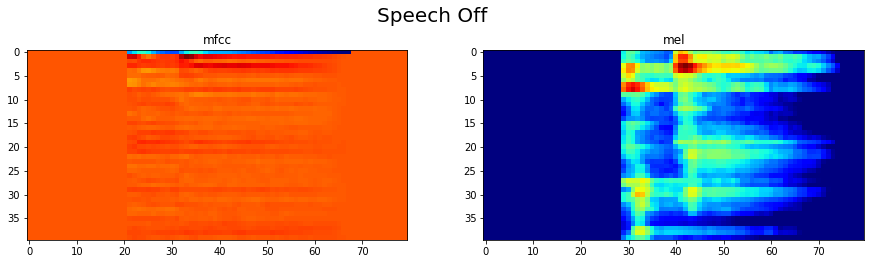

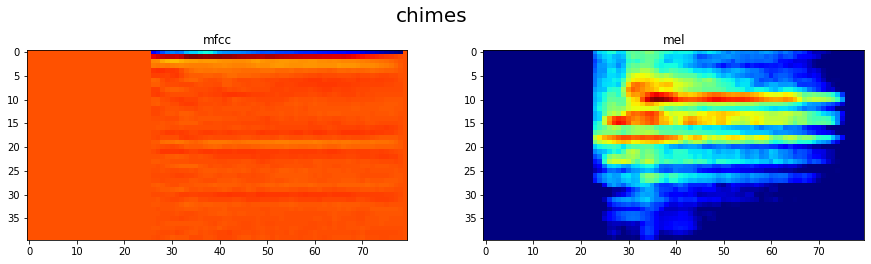

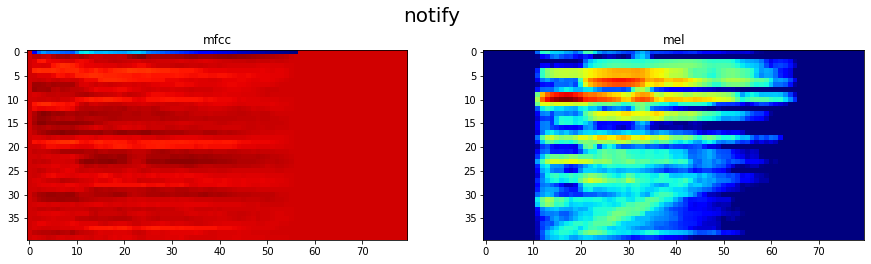

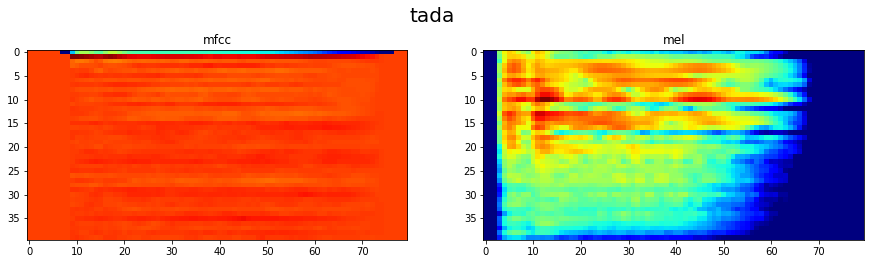

In [222]:
for i, wav in enumerate(zip(val_mfcc, val_mel)):
    plt.figure(figsize=(15,4))
    plt.suptitle(wav_list[i].split('/')[-1].split('.')[0], fontsize=20)
    for j, wav_c in enumerate(wav):
        plt.subplot(1, 2, 1+j)
        if j == 0:
            plt.title('mfcc')
        else:
            plt.title('mel')
        plt.imshow(wav_c, cmap='jet')
    plt.show()
    print('\n')